## Libs

In [ ]:
!pip install dagshub
!pip install mlflow
!pip install pydantic==1.10.9

In [3]:
import dagshub
import mlflow

import os
import PIL

import pandas as pd
import numpy as np
import pickle
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#enter you path to the chapter drive shortcut
root_path = '/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/'

In [ ]:
#  input your user id from dagshub
your_dagshub_user = 'your_dagshub_username'

## Functions

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, classification_report

def evaluate_classification_multi(y_true, y_pred):
    """Evaluates a classification model by calculating and printing various metrics.

    Args:
        y_true (array): True class values.
        y_pred (_type_): Predicted class values.

    Returns:
        dictionary: Dictionary containing various evaluation metrics including Accuracy, F1 Score, Recall, Confusion Matrix.
    """
    classes = ['Cescospora','Healthy','Miner','Phoma','Rust']

    # 1 - Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # 2 - Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # 3 - F1 Score
    f1 = f1_score(y_true, y_pred, average='macro')

    # 4 - Recall for each class
    recall_each_class = recall_score(y_true, y_pred, average=None)
    recall_dict = {classes[i]: recall for i, recall in enumerate(recall_each_class)}

    # 5 - Print Classification Report
    print(classification_report(y_true, y_pred))

    metrics = {
        'Accuracy': round(accuracy,2),
        'F1 Score macro': round(f1,2),
        'Cescospora Recall': round(recall_dict['Cescospora'],2),
        'Healthy Recall': round(recall_dict['Healthy'],2),
        'Miner Recall': round(recall_dict['Miner'],2),
        'Phoma Recall': round(recall_dict['Phoma'],2),
        'Rust Recall': round(recall_dict['Rust'],2),
        'Confusion Matrix': conf_matrix
    }

    return metrics


In [53]:
def mlflow_track(experiment_name, metrics,model,X,strategy,preprocess,split,obs,loss,metrics_optmizer,learning_rate,train_batch,val_batch):
    """Tracks machine learning experiments using MLflow, including tagging and logging various parameters and metrics.

    Args:
        experiment_name (str): Name of the experiment for grouping and filtering purposes.
        metrics (dict): Dictionary containing evaluation metrics, such as ROC AUC, F1 Score, Recall, TP Rate, FP Rate, etc.
        model (str): Model used in the experiment.
        X (DataFrame): DataFrame containing the features used in the model.
        strategy (str): Strategy employed in the experiment.
        preprocess (str): Preprocessing technique used.
        split (str): Description of the data splitting strategy.
        threshold_defined (float): Manually defined threshold used in predictions.
        obs (str): Any additional observations or notes related to the experiment.

    Note:
        The function uses MLflow to set up an experiment with the given name, tags the experiment with the specified parameters,
        and logs metrics for the experiment. It also ends the current MLflow run after logging, so each call to this function
        should correspond to a distinct experiment run.

    """

    #label para filtrar os experimentos
    mlflow.set_experiment(experiment_name=experiment_name)

    #tags para organizar os experimentos
    #para cada experimento novo eu altero os parâmetros para armazenar as métricas de cada configuração e combinação de exeprimento
    tags = {
            "model": model,
            "strategy":strategy,
            "features": X,
            "preprocess":preprocess,
            "split":split,
            'obs':obs
        }


    #salvando métricas no experimento setado acima
    mlflow.set_tags(tags)

    #para cada experimento novo eu altero os parâmetros para armazenar as métricas de cada configuração e combinação de exeprimento
    # mlflow.log_param("random_state", random_state)
    mlflow.log_param("loss", loss)
    mlflow.log_param("metrics_optmizer", metrics_optmizer)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("train_batch", train_batch)
    mlflow.log_param("val_batch", val_batch)


    mlflow.log_metric("Accuracy", metrics['Accuracy'])
    mlflow.log_metric("F1 Score macro", metrics['F1 Score macro'])
    mlflow.log_metric("Cescospora Recall", metrics['Cescospora Recall'])
    mlflow.log_metric("Healthy Recall", metrics['Healthy Recall'])
    mlflow.log_metric("Miner Recall", metrics['Miner Recall'])
    mlflow.log_metric("Phoma Recall", metrics['Phoma Recall'])
    mlflow.log_metric("Rust Recall", metrics['Rust Recall'])

    #para fechar a conexão anterior, sempre fechar a conexão depois de iniciar cada experimento
    mlflow.end_run()

## Read data strategy 002

In [8]:
folders = ['Cescospora','Healthy','Miner','Phoma','Rust']

In [9]:
# Inicialize uma lista para armazenar as informações
data = []

for i in range(len(folders)):
  # specific path to strategy
  path_to_file = f'Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/{folders[i]}'

  # all files
  files = os.listdir(root_path + path_to_file)


  for file in files:
    data.append({'target': folders[i], 'file_name': file, 'file_path': root_path + path_to_file + '/' + file})

# dataframe create
df_train = pd.DataFrame(data)


In [10]:
df_train

,target,file_name,file_path
0,Cescospora,IMG_20221126_110914-434x768_jpg.rf.6a1c257ed62...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
1,Cescospora,IMG_2293-576x768_JPG.rf.3974d5d3b700f658b1a66e...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
2,Cescospora,IMG_20221126_105553-576x768_jpg.rf.8cf6b08b8c1...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
3,Cescospora,IMG_20221126_111637-1022x768_jpg.rf.ed2be8e168...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
4,Cescospora,IMG_20221126_105748-576x768_jpg.rf.1113e5f2c72...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
...,...,...,...
4439,Rust,20221126_115243-432x768_jpg.rf.edd7a6bbeec6f7f...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
4440,Rust,IMG_20221126_120031-576x768_jpg.rf.d1f8f7f9a30...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
4441,Rust,IMG_20221126_110145-576x768_jpg.rf.e7b162210ca...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
4442,Rust,IMG_20221126_115400-576x768_jpg.rf.ea77d809fa1...,/content/drive/MyDrive/SaoPauloChapter_Plants-...


In [11]:
df_train['file_path'].iloc[0]

'/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/Cescospora/IMG_20221126_110914-434x768_jpg.rf.6a1c257ed62e2016f1df8e6853b37fa9.jpg'

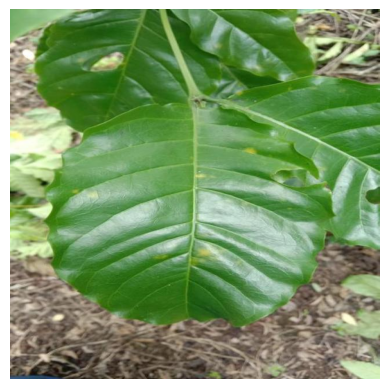

In [12]:
img = PIL.Image.open(df_train['file_path'].iloc[0])

plt.imshow(img)
plt.axis('off')
plt.show()

## read test and val data

In [13]:
# Inicialize uma lista para armazenar as informações
data = []

for i in range(len(folders)):
  # specific file path
  path_to_file = f'Task-4-Model(s) Building/data/000_test_and_val_dataset_resampled/{folders[i]}'

  # all files
  files = os.listdir(root_path + path_to_file)

  for file in files:
    data.append({'target': folders[i], 'file_name': file, 'file_path': root_path + path_to_file + '/' + file})

# dataframe create
df_val_test = pd.DataFrame(data)



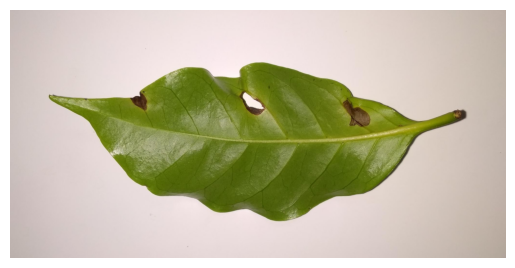

In [14]:
img = PIL.Image.open(df_val_test['file_path'].iloc[0])

plt.imshow(img)
plt.axis('off')
plt.show()

In [15]:
df_val_test

,target,file_name,file_path
0,Cescospora,423_jpg.rf.855240bd18e70f2a27dcc3766b669490.jpg,/content/drive/MyDrive/SaoPauloChapter_Plants-...
1,Cescospora,489_jpg.rf.b7622f0fc71c25a5b40c42f29cdd0ed0.jpg,/content/drive/MyDrive/SaoPauloChapter_Plants-...
2,Cescospora,264_jpg.rf.f08075fd50ad0e20f878cbf79aa3cce2.jpg,/content/drive/MyDrive/SaoPauloChapter_Plants-...
3,Cescospora,1506_jpg.rf.ee7d5eb52a64fc620bb5b030860911a6.jpg,/content/drive/MyDrive/SaoPauloChapter_Plants-...
4,Cescospora,358_jpg.rf.7b8520eae816f929afe42c6bab51e87f.jpg,/content/drive/MyDrive/SaoPauloChapter_Plants-...
...,...,...,...
2295,Rust,769_jpg.rf.95cca684033c0f8bc3613fadf84a4561.jpg,/content/drive/MyDrive/SaoPauloChapter_Plants-...
2296,Rust,1729_jpg.rf.e607bcf04997257fb97d92a9f7fe1ea5.jpg,/content/drive/MyDrive/SaoPauloChapter_Plants-...
2297,Rust,1706_jpg.rf.ded1425fe21145b4441951345998408f.jpg,/content/drive/MyDrive/SaoPauloChapter_Plants-...
2298,Rust,140_jpg.rf.de16ed5b1da47150a394d990fd5860cb.jpg,/content/drive/MyDrive/SaoPauloChapter_Plants-...


## separate val and test


In [16]:
# split data keeping the same quantity of each label in each dataset
df_val, df_test = train_test_split(df_val_test, test_size=0.5, stratify=df_val_test['target'], random_state=42)


In [17]:
df_val.groupby('target').count()

,file_name,file_path
target,,
Cescospora,56,56
Healthy,395,395
Miner,185,185
Phoma,53,53
Rust,461,461


In [18]:
df_test.groupby('target').count()

,file_name,file_path
target,,
Cescospora,56,56
Healthy,396,396
Miner,184,184
Phoma,54,54
Rust,460,460


## Modeling

### ResNet50 fine tuned

In [21]:
df_train

,target,file_name,file_path
0,Cescospora,IMG_20221126_110914-434x768_jpg.rf.6a1c257ed62...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
1,Cescospora,IMG_2293-576x768_JPG.rf.3974d5d3b700f658b1a66e...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
2,Cescospora,IMG_20221126_105553-576x768_jpg.rf.8cf6b08b8c1...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
3,Cescospora,IMG_20221126_111637-1022x768_jpg.rf.ed2be8e168...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
4,Cescospora,IMG_20221126_105748-576x768_jpg.rf.1113e5f2c72...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
...,...,...,...
4439,Rust,20221126_115243-432x768_jpg.rf.edd7a6bbeec6f7f...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
4440,Rust,IMG_20221126_120031-576x768_jpg.rf.d1f8f7f9a30...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
4441,Rust,IMG_20221126_110145-576x768_jpg.rf.e7b162210ca...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
4442,Rust,IMG_20221126_115400-576x768_jpg.rf.ea77d809fa1...,/content/drive/MyDrive/SaoPauloChapter_Plants-...


In [19]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((224, 224))

In [20]:
resnet_model = keras.applications.resnet50.ResNet50(include_top=False,
                                                    input_tensor=tf.keras.Input(shape=(224,224,3))
                                                   )
# resnet_model.summary()

94765736/94765736 [==============================] - 0s 0us/step


In [22]:
resnet_model.output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [23]:
# convert to Sequential model, omit the last layer
model = keras.models.Sequential()

model.add(resnet_model)

# set trainable=False for all layers
# we don't want to train them again
for layer in model.layers:
    layer.trainable = False

#add a last 1 neuron in last layer
# model.add(layers.Dense(4096))
# model.add(layers.Dense(2048))
# model.add(layers.Dense(1024))
# model.add(layers.Dense(1024))
# model.add(layers.Dense(256))
# model.add(layers.Dense(128))
# model.add(layers.Dense(64))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(1, activation='linear')) # colcoar função de ativção linear

#model.add(layers.Dense(1024))
#model.add(layers.Dense(512))
#model.add(layers.Dense(256))
#model.add(layers.Dense(128))
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(1))

#model.add(layers.Conv2D(2048, (1,1), kernel_regularizer=keras.regularizers.l2(0.01), activation='elu'))
#model.add(layers.Conv2D(2048, (1,1), kernel_regularizer=keras.regularizers.l1(0.01), activation='elu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2048))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(4096))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 2048)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dropout (Dropout)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 2048)              37750784  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                        

In [24]:
# loss and optimizer
loss = 'categorical_crossentropy'
#optim = keras.optimizers.Adam(learning_rate=0.0000001)
optim = keras.optimizers.Adam(learning_rate=0.00001)
#optim = tf.keras.optimizers.RMSprop(0.00001)
metrics = ['accuracy']

model.compile(optimizer=optim, loss=loss, metrics=metrics)


# get the preprocessing function of this model
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [25]:
# Generate batches of tensor image data with real-time data augmentation.
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               #rescale=1.0/255.0,
                                #                                        rotation_range=360, # Degree range for random rotations
                                 #                                      width_shift_range=0.2, # Range for random horizontal shifts
                                  #                                    height_shift_range=0.2, # Range for random vertical shifts
                                   #                                     zoom_range=0.2, # Range for random zoom
                                    #                                     horizontal_flip=True, # Randomly flip inputs horizontally
                                     #                                   vertical_flip=True) # Randomly flip inputs vertically
)


valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               #rescale=1.0/255.0
)



In [26]:
df_train

,target,file_name,file_path
0,Cescospora,IMG_20221126_110914-434x768_jpg.rf.6a1c257ed62...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
1,Cescospora,IMG_2293-576x768_JPG.rf.3974d5d3b700f658b1a66e...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
2,Cescospora,IMG_20221126_105553-576x768_jpg.rf.8cf6b08b8c1...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
3,Cescospora,IMG_20221126_111637-1022x768_jpg.rf.ed2be8e168...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
4,Cescospora,IMG_20221126_105748-576x768_jpg.rf.1113e5f2c72...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
...,...,...,...
4439,Rust,20221126_115243-432x768_jpg.rf.edd7a6bbeec6f7f...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
4440,Rust,IMG_20221126_120031-576x768_jpg.rf.d1f8f7f9a30...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
4441,Rust,IMG_20221126_110145-576x768_jpg.rf.e7b162210ca...,/content/drive/MyDrive/SaoPauloChapter_Plants-...
4442,Rust,IMG_20221126_115400-576x768_jpg.rf.ea77d809fa1...,/content/drive/MyDrive/SaoPauloChapter_Plants-...


In [55]:
train_batches = train_gen.flow_from_dataframe(
    df_train,
    directory= None,
    x_col='file_path',
    y_col='target',
    augment=True,
    target_size=DEFAULT_IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=128,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="jpg",
    subset=None,
    interpolation="nearest"
)

val_batches = valid_gen.flow_from_dataframe(
    df_val,
    directory= None,
    x_col='file_path',
    y_col='target',
    target_size=DEFAULT_IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=128,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="jpg",
    subset=None,
    interpolation="nearest"
)

Found 4444 validated image filenames belonging to 5 classes.
Found 1150 validated image filenames belonging to 5 classes.


In [ ]:
epochs = 10

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta = 1,
    patience=10,
    verbose=1
)

history = model.fit(train_batches, validation_data=val_batches,
          callbacks=[early_stopping],
          epochs=epochs, verbose=1)

Epoch 1/10
35/35 [==============================] - 1986s 57s/step - loss: 0.5543 - accuracy: 0.8486 - val_loss: 7.8509 - val_accuracy: 0.3313
Epoch 2/10
35/35 [==============================] - 149s 4s/step - loss: 0.5164 - accuracy: 0.8569 - val_loss: 7.6611 - val_accuracy: 0.3313
Epoch 3/10
28/35 [=======================>......] - ETA: 13s - loss: 0.4877 - accuracy: 0.8619

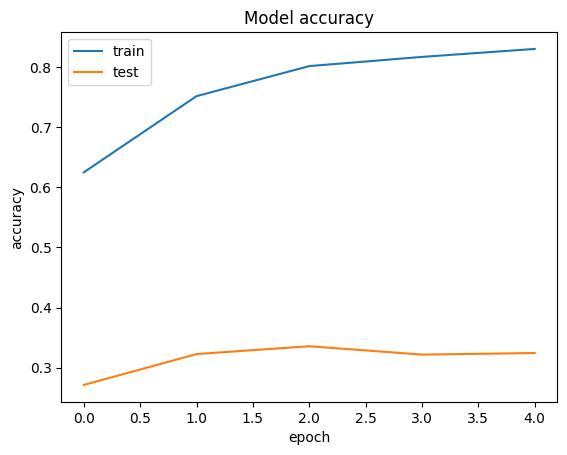

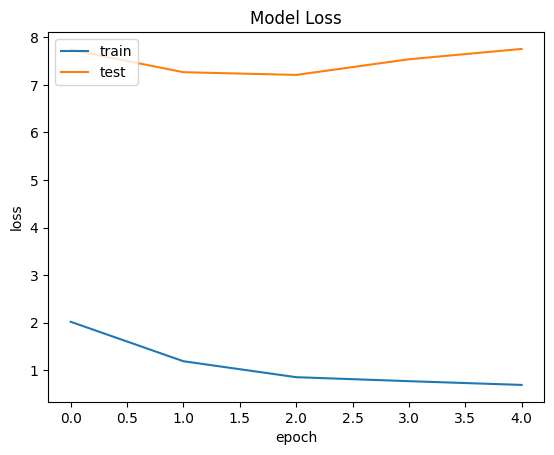

In [ ]:
# list all data in history
#print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Evaluate predictions in test set

In [28]:
#model = load_model('/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-4-Model(s) Building/models/baseline_resnet50.h5')

In [29]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               #rescale=1.0/255.0
)

test_generator  = test_datagen.flow_from_dataframe(
        df_test,
        directory=None,
        x_col="file_path",
        y_col = None,
        target_size=DEFAULT_IMAGE_SIZE,
        color_mode="rgb",
        shuffle = False,
        class_mode=None,
        batch_size=1
        )
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = model.predict_generator(test_generator ,steps = nb_samples)


Found 1150 validated image filenames.


<ipython-input-29-0b97fee1bcdc>:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator ,steps = nb_samples)


In [36]:
predict

array([[2.8970338e-02, 1.3797552e-02, 1.6798283e-03, 5.1123803e-09,
        9.5555228e-01],
       [3.3580149e-05, 1.4365260e-03, 2.3408285e-04, 4.9821492e-03,
        9.9331361e-01],
       [1.8770322e-06, 1.4263021e-08, 2.8027460e-04, 9.5701507e-13,
        9.9971777e-01],
       ...,
       [1.8620295e-06, 4.2994529e-02, 9.6746261e-04, 1.5267570e-07,
        9.5603603e-01],
       [1.5532116e-04, 1.0096436e-05, 1.1455822e-06, 2.1588715e-08,
        9.9983335e-01],
       [1.9842939e-02, 1.8523296e-03, 1.4848881e-05, 4.1714475e-07,
        9.7828943e-01]], dtype=float32)

In [32]:
train_batches.class_indices

{'Cescospora': 0, 'Healthy': 1, 'Miner': 2, 'Phoma': 3, 'Rust': 4}

In [38]:
#transform predictions in classes
class_indices = train_batches.class_indices
class_indices = {v: k for k, v in class_indices.items()}
predicted_class_indices = np.argmax(predict, axis=1)
predicted_class_names = [class_indices[i] for i in predicted_class_indices]


In [39]:
df_test['predicted'] = predicted_class_names

In [40]:
df_test

,target,file_name,file_path,predicted
1605,Rust,name36.jpg,/content/drive/MyDrive/SaoPauloChapter_Plants-...,Rust
825,Healthy,C11P34H1.jpg,/content/drive/MyDrive/SaoPauloChapter_Plants-...,Rust
1509,Rust,name231.jpg,/content/drive/MyDrive/SaoPauloChapter_Plants-...,Rust
2286,Rust,770_jpg.rf.dd87f9ab68913a85219ed70384f4ffd0.jpg,/content/drive/MyDrive/SaoPauloChapter_Plants-...,Miner
1604,Rust,name34.jpg,/content/drive/MyDrive/SaoPauloChapter_Plants-...,Rust
...,...,...,...,...
1500,Rust,name228.jpg,/content/drive/MyDrive/SaoPauloChapter_Plants-...,Healthy
1678,Rust,410_jpg.rf.fe8de8312866d160e61c168ffbd027ba.jpg,/content/drive/MyDrive/SaoPauloChapter_Plants-...,Phoma
1433,Rust,name164.jpg,/content/drive/MyDrive/SaoPauloChapter_Plants-...,Rust
793,Healthy,C11P10E1.jpg,/content/drive/MyDrive/SaoPauloChapter_Plants-...,Rust


In [41]:
#precision
print(classification_report(df_test['target'], df_test['predicted'], target_names=['Cescospora','Healthy','Miner','Phoma','Rust']))

              precision    recall  f1-score   support

  Cescospora       0.00      0.00      0.00        56
     Healthy       0.12      0.01      0.02       396
       Miner       0.43      0.66      0.52       184
       Phoma       0.12      0.35      0.18        54
        Rust       0.31      0.45      0.37       460

    accuracy                           0.31      1150
   macro avg       0.20      0.30      0.22      1150
weighted avg       0.24      0.31      0.25      1150



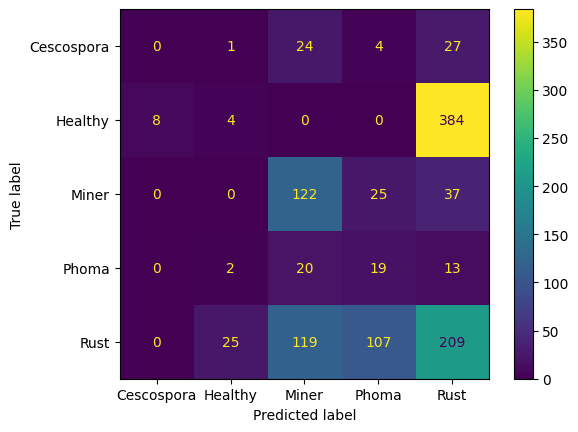

In [42]:
confusion_matrix = confusion_matrix(df_test['target'], df_test['predicted'])
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = ['Cescospora','Healthy','Miner','Phoma','Rust'])
cm_display.plot()
plt.show()

In [45]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, classification_report
metrics = evaluate_classification_multi(df_test['target'], df_test['predicted'])

              precision    recall  f1-score   support

  Cescospora       0.00      0.00      0.00        56
     Healthy       0.12      0.01      0.02       396
       Miner       0.43      0.66      0.52       184
       Phoma       0.12      0.35      0.18        54
        Rust       0.31      0.45      0.37       460

    accuracy                           0.31      1150
   macro avg       0.20      0.30      0.22      1150
weighted avg       0.24      0.31      0.25      1150



In [46]:
metrics

{'Accuracy': 0.31,
 'F1 Score macro': 0.22,
 'Cescospora Recall': 0.0,
 'Healthy Recall': 0.01,
 'Miner Recall': 0.66,
 'Phoma Recall': 0.35,
 'Rust Recall': 0.45,
 'Confusion Matrix': array([[  0,   1,  24,   4,  27],
        [  8,   4,   0,   0, 384],
        [  0,   0, 122,  25,  37],
        [  0,   2,  20,  19,  13],
        [  0,  25, 119, 107, 209]])}

In [ ]:
#model.save("/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-4-Model(s) Building/models/baseline_resnet50.h5")

# MLFLOW saving experiment

Add your parameters for this experiment.

In [49]:
strategy = 'fine tuned resnet 50 using strategy 002 dataset'
preprocess = 'augmentation, resize 250x250, interpolation nearest, relu and softmax last layers, optmize adam'
split = 'already splited'
obs = 'using the test and val dataset provided from task 2, with no augmentation or preprocessing'
X = 'all images on strategy 2 dataset'
modelname = 'resnet 50 fine tuned'

loss = 'categorical_crossentropy'
metrics_optmizer = 'accuracy'
learning_rate=0.00001
train_batch = 32
val_batch = 32


In [50]:
#don't need to change
dagshub.init("mlflow_free_omdena",your_dagshub_user, mlflow=True)

Repository initialized!

In [51]:
#don't need to change
mlflow.set_tracking_uri('https://dagshub.com/lucasvascrocha/mlflow_free_omdena.mlflow')

In [54]:
experiment_name = 'approach1'
mlflow_track(experiment_name, metrics,model,X,strategy,preprocess,split,obs,loss,metrics_optmizer,learning_rate,train_batch,val_batch)


2023/09/06 21:12:09 INFO mlflow.tracking.fluent: Experiment with name 'approach1' does not exist. Creating a new experiment.
